To copy this template: File -> Save a Copy in Drive

***DISCLAIMER**: In case of any discrepancy in the assignment instruction, please refer to the `PDF` document.*

# Problem 4 - Siamese Network for Face Recognition

## 4.1

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [4]:
!wget https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
!rm -rf data
!unzip "at&t.zip" -d .

--2023-11-07 01:43:48--  https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maticvl/dataHacker/master/DATA/at%26t.zip [following]
--2023-11-07 01:43:49--  https://raw.githubusercontent.com/maticvl/dataHacker/master/DATA/at%26t.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3797060 (3.6M) [application/zip]
Saving to: ‘at&t.zip.3’

at&t.zip.3          100%[===================>]   3.62M  --.-KB/s    in 0.06s   

2023-11-07 01:43:49 (60.5 MB/s) - ‘at&t.zip.3’ saved [3797060/3797060]

Archive:  at&t.zip
   creating: ./data/
   cre

In [5]:
# Load the training dataset
folder_dataset = datasets.ImageFolder(root="./data/faces/training/")

In [6]:
# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

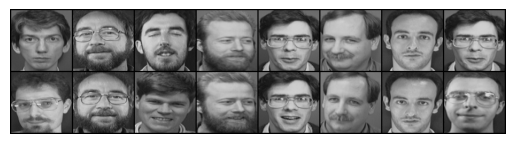

[1. 0. 1. 0. 0. 0. 0. 1.]


In [7]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [8]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256,2)
        )

    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [9]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [10]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

Epoch number 0
 Current loss 1.8733782768249512

Epoch number 1
 Current loss 1.2373216152191162

Epoch number 2
 Current loss 0.8472501039505005

Epoch number 3
 Current loss 1.0552818775177002

Epoch number 4
 Current loss 0.9354566335678101

Epoch number 5
 Current loss 0.7525498867034912

Epoch number 6
 Current loss 0.8034225702285767

Epoch number 7
 Current loss 0.6356304883956909

Epoch number 8
 Current loss 1.1966607570648193

Epoch number 9
 Current loss 1.1073168516159058

Epoch number 10
 Current loss 0.6298424005508423

Epoch number 11
 Current loss 0.6724653244018555

Epoch number 12
 Current loss 0.4248591661453247

Epoch number 13
 Current loss 0.3576408922672272

Epoch number 14
 Current loss 0.4200040102005005

Epoch number 15
 Current loss 0.33996880054473877

Epoch number 16
 Current loss 0.39384379982948303

Epoch number 17
 Current loss 0.34016597270965576

Epoch number 18
 Current loss 0.2865794897079468

Epoch number 19
 Current loss 0.3605325520038605

Epoch n

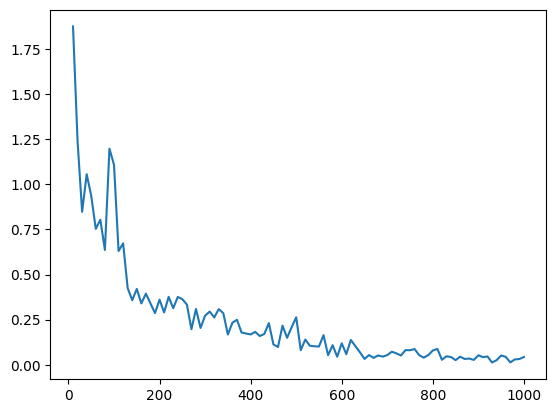

In [12]:
counter = []
loss_history = []
iteration_number= 0

# Iterate throught the epochs
for epoch in range(100):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

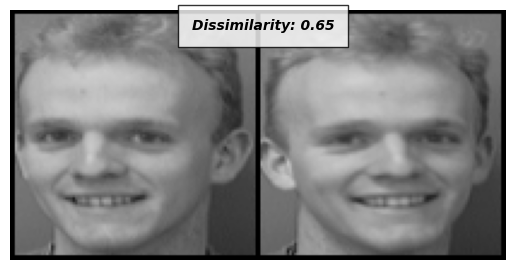

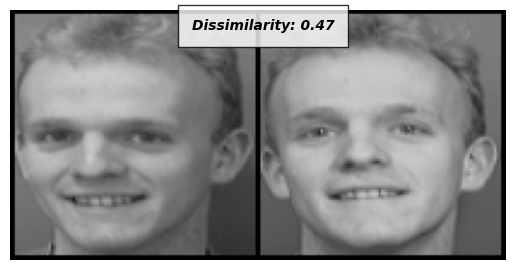

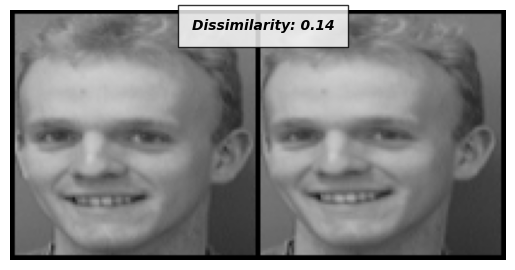

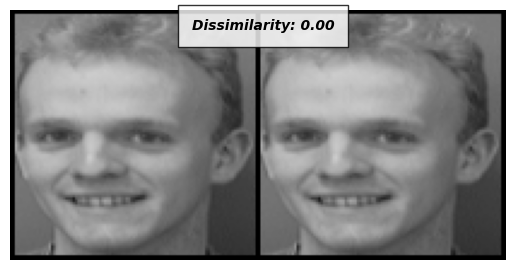

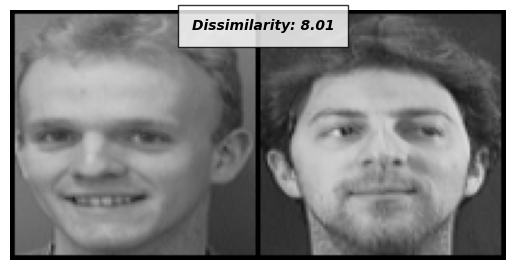

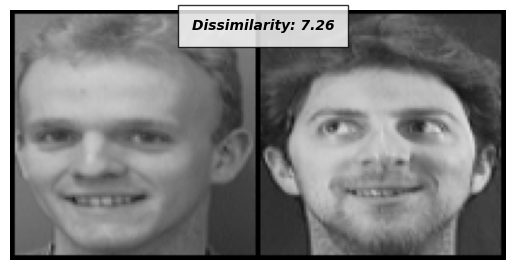

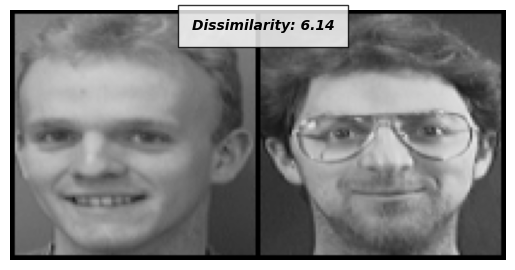

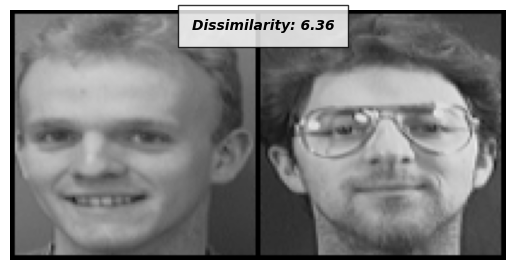

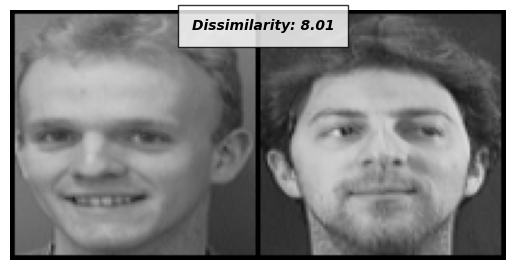

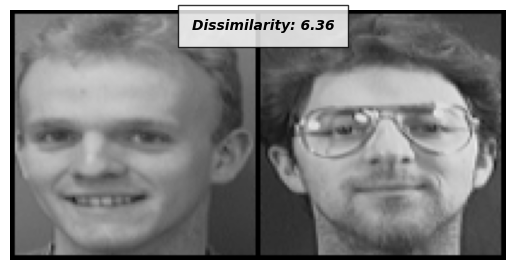

In [13]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="./data/faces/testing/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(10):
    # Iterate over 10 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)

    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

## 4.2

In [14]:
from sklearn.metrics import accuracy_score

def find_optimal_threshold(model, loader):
    model.eval()

    distance_list = []
    ground_truth = []

    # Disable gradients for validation
    with torch.no_grad():
        for idx, (batch_img0, batch_img1, target) in enumerate(loader):
            # Compute model output
            output_img0, output_img1 = model(batch_img0.cuda(), batch_img1.cuda())
            dist = F.pairwise_distance(output_img0, output_img1)
            distance_list.extend(dist.cpu().numpy())
            ground_truth.extend(target.cpu().numpy())

    # Convert the accumulated distances and labels to numpy arrays
    distance_list = np.array(distance_list).flatten()
    ground_truth = np.array(ground_truth).flatten()

    # Specify a sequence of potential thresholds to test
    potential_thresholds = np.linspace(start=0, stop=5, num=100)  # Limit to 5 based on previous observation

    # Initialize variables to track the best threshold and its corresponding accuracy
    global optimal_threshold
    optimal_threshold = 0
    highest_acc = 0

    # Evaluate each threshold to find the most accurate one
    for t in potential_thresholds:
        pred_labels = (distance_list > t).astype(int)
        current_acc = accuracy_score(ground_truth, pred_labels)
        print(f"Evaluating Threshold: {t:.4f} - Current Accuracy: {current_acc:.4f}")
        if current_acc >= highest_acc:
            highest_acc = current_acc
            optimal_threshold = t

    return optimal_threshold, highest_acc

# Run the function to get the best threshold and accuracy
best_thresh, top_accuracy = find_optimal_threshold(net, train_dataloader)
print(f"Identified Optimal Threshold: {best_thresh:.4f}")
print(f"Maximum Accuracy Achieved: {top_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Evaluating Threshold: 0.0000 - Current Accuracy: 0.4703
Evaluating Threshold: 0.0505 - Current Accuracy: 0.5568
Evaluating Threshold: 0.1010 - Current Accuracy: 0.6243
Evaluating Threshold: 0.1515 - Current Accuracy: 0.7270
Evaluating Threshold: 0.2020 - Current Accuracy: 0.7973
Evaluating Threshold: 0.2525 - Current Accuracy: 0.8514
Evaluating Threshold: 0.3030 - Current Accuracy: 0.9000
Evaluating Threshold: 0.3535 - Current Accuracy: 0.9324
Evaluating Threshold: 0.4040 - Current Accuracy: 0.9514
Evaluating Threshold: 0.4545 - Current Accuracy: 0.9784
Evaluating Threshold: 0.5051 - Current Accuracy: 0.9865
Evaluating Threshold: 0.5556 - Current Accuracy: 0.9919
Evaluating Threshold: 0.6061 - Current Accuracy: 0.9946
Evaluating Threshold: 0.6566 - Current Accuracy: 0.9973
Evaluating Threshold: 0.7071 - Current Accuracy: 1.0000
Evaluating Threshold: 0.7576 - Current Accuracy: 1.0000
Evaluating Threshold: 0.8081 - Current Accuracy: 1.0000
Evaluating Threshold: 0.8586 - Current Accuracy:

In [15]:
print(optimal_threshold)
print(top_accuracy)

1.4141414141414141
1.0


**Answer:**

This model has an opitmal threshold of 1.41 and a mximum accuracy of 100% which may indicate that the model is overfitting to the training data.

## 4.3

In [16]:
#!unzip "/content/sample_data/MeGlass_120x120.zip" -d .

In [17]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
#file_path = '/content/MeGlass_120x120'
# Define a function to read image IDs from files
def read_image_ids(file_path):
    with open(file_path, 'r') as file:
        return file.read().splitlines()

# Function to pair image IDs with and without glasses
def pair_image_ids(ids_glasses, ids_no_glasses):
    paired = []
    count = 0
    for id_glass in ids_glasses:
        base_id = id_glass.split('@')[0]
        if base_id in ids_no_glasses:
            paired.append((id_glass, ids_no_glasses[base_id]))
            count += 1
    return paired, count

# Read image IDs from files
ids_with_glasses = read_image_ids('/content/sample_data/gallery_black_glass.txt')
ids_without_glasses = {id.split('@')[0]: id for id in read_image_ids('/content/sample_data/gallery_no_glass.txt')}

# Create a dictionary of paired IDs
pairs, num = pair_image_ids(ids_with_glasses, ids_without_glasses)

# MeGlass dataset directory
dataset_folder = "MeGlass_120x120"

# Custom dataset for the MeGlass dataset
class MeGlassDataset(Dataset):
    def __init__(self, directory, image_pairs, transform=None):
        self.directory = directory
        self.image_pairs = image_pairs
        self.transform = transform

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        with_id, without_id = self.image_pairs[idx]
        path_with = os.path.join(self.directory, with_id)
        path_without = os.path.join(self.directory, without_id)
        image_with = Image.open(path_with).convert('L')
        image_without = Image.open(path_without).convert('L')

        if self.transform:
            image_with = self.transform(image_with)
            image_without = self.transform(image_without)

        return image_with, image_without

# Transformation pipeline
transform_pipeline = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
])

# Initialize the dataset and dataloader
meglass_dataset = MeGlassDataset(dataset_folder, pairs, transform_pipeline)
meglass_dataloader = DataLoader(meglass_dataset, batch_size=1, shuffle=False)

# Network evaluation loop
net.eval()
match_counter = 0
for with_img, without_img in meglass_dataloader:
    with_img, without_img = with_img.cuda(), without_img.cuda()
    with_output, without_output = net(with_img, without_img)
    distance = F.pairwise_distance(with_output, without_output)

    # Count matches based on the distance
    if distance.item() < optimal_threshold:
        match_counter += 1

# Compute and print the match ratio
match_ratio = match_counter / num
print("Match ratio:", match_ratio)


Match ratio: 0.05380116959064327


**Answer:**

My model does not perform particulary well with a 5% accuracy of matching people with and without glasses.

## 4.4

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score
import numpy as np

# Define the Mining-Contrastive Loss class
class MiningContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(MiningContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        cos_sim = F.cosine_similarity(output1, output2)
        pos_loss = label * (1 - cos_sim)
        neg_loss = (1 - label) * F.relu(cos_sim - self.margin)
        loss = pos_loss + neg_loss
        return loss.mean()

# Define the function to determine the best threshold
def determine_threshold(net, dataloader):
    net.eval()
    cos_sims = []
    labels = []

    with torch.no_grad():
        for img0, img1, label in dataloader:
            img0, img1 = img0.cuda(), img1.cuda()
            output1, output2 = net(img0, img1)
            cos_sim = F.cosine_similarity(output1, output2)
            cos_sims.extend(cos_sim.cpu().numpy())
            labels.extend(label.cpu().numpy())

    best_accuracy = 0
    best_threshold = 0
    for threshold in np.linspace(0, 10, num=1000):
        predictions = (cos_sims > threshold).astype(int)
        accuracy = accuracy_score(labels, predictions)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold

    return best_threshold, best_accuracy

# Initialize the Siamese Network and criterion
net = SiameseNetwork().cuda()
criterion = MiningContrastiveLoss(margin=1.0)
optimizer = optim.Adam(net.parameters(), lr=0.0005)

# Training loop
for epoch in range(100):  # Number of epochs
    for i, (img0, img1, label) in enumerate(train_dataloader):
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()

        if i % 10 == 0:  # Log the training loss
            print(f"Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}")

# Determine the best threshold after training
threshold, accuracy = determine_threshold(net, train_dataloader)
print(f"Best Threshold: {threshold}")
print(f"Best Accuracy: {accuracy}")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 0, Batch: 0, Loss: 3.747147275134921e-05
Epoch: 1, Batch: 0, Loss: 7.038470357656479e-07
Epoch: 2, Batch: 0, Loss: 2.491287887096405e-08
Epoch: 3, Batch: 0, Loss: 1.867010723799467e-08
Epoch: 4, Batch: 0, Loss: 1.2660166248679161e-08
Epoch: 5, Batch: 0, Loss: 1.2689270079135895e-08
Epoch: 6, Batch: 0, Loss: 7.159542292356491e-09
Epoch: 7, Batch: 0, Loss: 1.525040715932846e-08
Epoch: 8, Batch: 0, Loss: 1.1175870895385742e-08
Epoch: 9, Batch: 0, Loss: 1.1583324521780014e-08
Epoch: 10, Batch: 0, Loss: 8.119968697428703e-09
Epoch: 11, Batch: 0, Loss: 6.170012056827545e-09
Epoch: 12, Batch: 0, Loss: 8.265487849712372e-09
Epoch: 13, Batch: 0, Loss: 1.0142684914171696e-08
Epoch: 14, Batch: 0, Loss: 8.847564458847046e-09
Epoch: 15, Batch: 0, Loss: 7.916241884231567e-09
Epoch: 16, Batch: 0, Loss: 6.461050361394882e-09
Epoch: 17, Batch: 0, Loss: 1.0710209608078003e-08
Epoch: 18, Batch: 0, Loss: 1.1539668776094913e-08
Epoch: 19, Batch: 0, Loss: 9.66247171163559e-09
Epoch: 20, Batch: 0, Los

In [24]:
print(f"Best Threshold: {threshold}")
print(f"Best Accuracy: {accuracy}")

Best Threshold: 1.001001001001001
Best Accuracy: 0.5216216216216216


**Answer:**
This model obtained a maximum accuracy of only 52% which indicates that it was definitely not over fitting the training data. Its optimal threshold is 1.00

## 4.5

In [25]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
#file_path = '/content/MeGlass_120x120'
# Define a function to read image IDs from files
def read_image_ids(file_path):
    with open(file_path, 'r') as file:
        return file.read().splitlines()

# Function to pair image IDs with and without glasses
def pair_image_ids(ids_glasses, ids_no_glasses):
    paired = []
    count = 0
    for id_glass in ids_glasses:
        base_id = id_glass.split('@')[0]
        if base_id in ids_no_glasses:
            paired.append((id_glass, ids_no_glasses[base_id]))
            count += 1
    return paired, count

# Read image IDs from files
ids_with_glasses = read_image_ids('/content/sample_data/gallery_black_glass.txt')
ids_without_glasses = {id.split('@')[0]: id for id in read_image_ids('/content/sample_data/gallery_no_glass.txt')}

# Create a dictionary of paired IDs
pairs, num = pair_image_ids(ids_with_glasses, ids_without_glasses)

# MeGlass dataset directory
dataset_folder = "MeGlass_120x120"

# Custom dataset for the MeGlass dataset
class MeGlassDataset(Dataset):
    def __init__(self, directory, image_pairs, transform=None):
        self.directory = directory
        self.image_pairs = image_pairs
        self.transform = transform

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        with_id, without_id = self.image_pairs[idx]
        path_with = os.path.join(self.directory, with_id)
        path_without = os.path.join(self.directory, without_id)
        image_with = Image.open(path_with).convert('L')
        image_without = Image.open(path_without).convert('L')

        if self.transform:
            image_with = self.transform(image_with)
            image_without = self.transform(image_without)

        return image_with, image_without

# Transformation pipeline
transform_pipeline = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
])

# Initialize the dataset and dataloader
meglass_dataset = MeGlassDataset(dataset_folder, pairs, transform_pipeline)
meglass_dataloader = DataLoader(meglass_dataset, batch_size=1, shuffle=False)

# Network evaluation loop
net.eval()
match_counter = 0
for with_img, without_img in meglass_dataloader:
    with_img, without_img = with_img.cuda(), without_img.cuda()
    with_output, without_output = net(with_img, without_img)
    distance = F.pairwise_distance(with_output, without_output)

    # Count matches based on the distance
    if distance.item() < optimal_threshold:
        match_counter += 1

# Compute and print the match ratio
match_ratio = match_counter / num
print("Match ratio:", match_ratio)


Match ratio: 0.8333333333333334


**Answer:**

The model with Mining contrastive loss on the saimese network is the better performing model with an accuracy of 83.33% looking at people with and without glasses. This indicates that the use of mining contrastive loss function improves the model's perfomance at identifying people with and without glasses.